In [9]:
import numpy as np
import torch
import torchvision as tv
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math
%matplotlib inline

In [10]:
def nlfunction(x):
    return (x**3 + 2*x**2 + 3*x + 1)    

In [11]:
X = torch.rand((1000, 1))
Y = nlfunction(X)

In [12]:
def calcParams(inputModel):
    val = sum(params.numel() for params in inputModel.parameters() if params.requires_grad)
    return val

In [13]:
class VisOptimizeModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, val):
        val = F.relu(self.fc1(val))
        val = F.relu(self.fc2(val))
        val = self.fc3(val)
        return val

In [14]:
mdl2 = VisOptimizeModel()
lossFunc = nn.MSELoss()
opt = optim.Adam(mdl2.parameters(), lr=0.001)
print(calcParams(mdl2))

609


In [15]:
# Training of network to visualize optimization
trainingIteration = 8
EPOCHS = 330 
epochNum = round(EPOCHS / 3)
layer1Connections = 1 * 16
layer2Connections = 16 * 32
layer3Connections = 32 * 1
totModelConnections = layer1Connections + layer2Connections + layer3Connections

# Number of training iterations for visualization
costList = []
counter = 0
layer2WeightsTensor = torch.zeros((trainingIteration * epochNum, layer2Connections))
wholeModelWeightsTensor = torch.zeros((trainingIteration * epochNum, totModelConnections))
costTensor = torch.zeros((trainingIteration * epochNum, 1))
for trainingIndex in range(trainingIteration): 
    
    # Training of individual series, reset model on every series
    mdl2 = VisOptimizeModel()
    lossFunc = nn.MSELoss()
    opt = optim.Adam(mdl2.parameters(), lr=0.001)
    for epochIndex in range(EPOCHS):
        mdl2.zero_grad()
        output = mdl2(X)
        cost = lossFunc(output, Y)
        cost.backward()
        opt.step()

        # Every 3 epochs, collect weights and cost
        if epochIndex % 3 == 0:
            # Gather weights of the model
            layer1Weights = torch.reshape(torch.flatten(mdl2.fc1.weight), (1, layer1Connections))
            layer2Weights = torch.reshape(torch.flatten(mdl2.fc2.weight), (1, layer2Connections))
            layer3Weights = torch.reshape(torch.flatten(mdl2.fc3.weight), (1, layer3Connections))
            # Combine weights for whole model
            temp = torch.cat((layer2Weights, layer1Weights), dim=1)
            wholeModelWeights = torch.cat((temp, layer3Weights), dim=1)
            # Save weights and cost for later
            wholeModelWeightsTensor[counter] = wholeModelWeights
            layer2WeightsTensor[counter] = layer2Weights
            costTensor[counter] = cost
            counter += 1

In [16]:
def implementationPca(inputArray, dimToReturn):
    m, n = inputArray.shape
    
    # Calculate means and Normalize
    meansOfInputs = np.array([np.mean(inputArray[:, index]) for index in range(n)])
    inputNormalized = inputArray - meansOfInputs
    
    # Calculate eigenvalues and eigenvectors
    mtr = np.dot(np.transpose(inputNormalized),inputNormalized)
    eigenvalues, eigenvectors = np.linalg.eig(mtr)
    pairs = [(np.abs(eigenvalues[index]), eigenvectors[:, index]) for index in range(n)]

    # Sort pairs and return dimensions requested
    pairs.sort(key=lambda x: x[0], reverse=True)
    featFromData = np.array([value[1] for value in pairs[:dimToReturn]])
    reducedDimData = np.dot(inputNormalized, np.transpose(featFromData))
    return reducedDimData

In [17]:
# Reduce dimensions using PCA
layer2Reduced = layer2WeightsTensor.detach().cpu().numpy()
wholeModelReduced = wholeModelWeightsTensor.detach().cpu().numpy()
costVector = costTensor.detach().cpu().numpy()
layer2Reduced = implementationPca(layer2Reduced, 2)
wholeModelReduced = implementationPca(wholeModelReduced, 2)

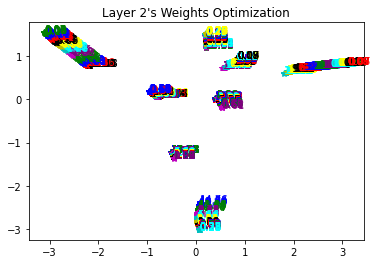

In [18]:
# Plot optimization of Layer 2 of NN
colorList = ['r*', 'b*', 'g*', 'm*', 'c*', 'y*', 'k*']
colorNameList = ["red", "blue", "green", "purple", "cyan", "yellow", 'black']
counter = 0
colorCounter = 0
for pair in layer2Reduced:
    if (counter % 10) == 0 and counter != 0:
        # Change Color
        if colorCounter >= len(colorList) - 1:
            colorCounter = 0
        else:
            colorCounter += 1
    plt.plot(pair[0], pair[1], colorList[colorCounter])
    plt.annotate(str(round(costVector[counter][0], 2)), (pair[0], pair[1]), color=colorNameList[colorCounter])
    counter += 1
plt.title("Layer 2's Weights Optimization") 
plt.show()

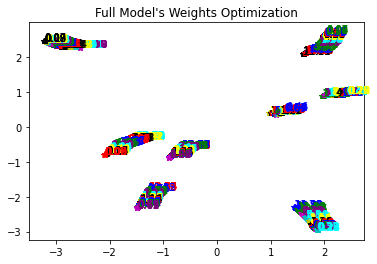

In [19]:
# Plot optimization of Whole Model of NN
counter = 0
colorCounter = 0
for pair in wholeModelReduced:
    if (counter % 10) == 0 and counter != 0:
        if colorCounter >= len(colorList) - 1:
            colorCounter = 0
        else:
            colorCounter += 1
    plt.plot(pair[0], pair[1], colorList[colorCounter])
    plt.annotate(str(round(costVector[counter][0], 2)), (pair[0], pair[1]), color=colorNameList[colorCounter])
    counter += 1
plt.title("Full Model's Weights Optimization")
plt.show()